In [82]:
####cookie arima
### Model Comparsions:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
warnings.filterwarnings("ignore")
%matplotlib inline

In [105]:
pip install pmdarima

     -------------------------------------- 572.7/572.7 kB 7.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [83]:
### LOAD & SELECTION
dff=pd.read_csv("C:/Users/91882/Documents/THS_SKU_Forecast_Model_Dataset.csv")
df1=dff[(dff["Profit_Center"].str.upper()=='COOKIE') | (dff["Profit_Center"].str.upper()=='CRACKER')]
df1=df1[["SKU","Month","Quantity_Sales","Profit_Center"]]
df2=df1.groupby(by=["Profit_Center","SKU"])["Quantity_Sales"].agg({"sum"})
df3=df2.reset_index()

In [84]:
# Checking Incorrect data formats
dff[pd.to_datetime(dff['Month'],errors='coerce').isna()]

,Profit_Center,Month,SKU,Quantity_Sales


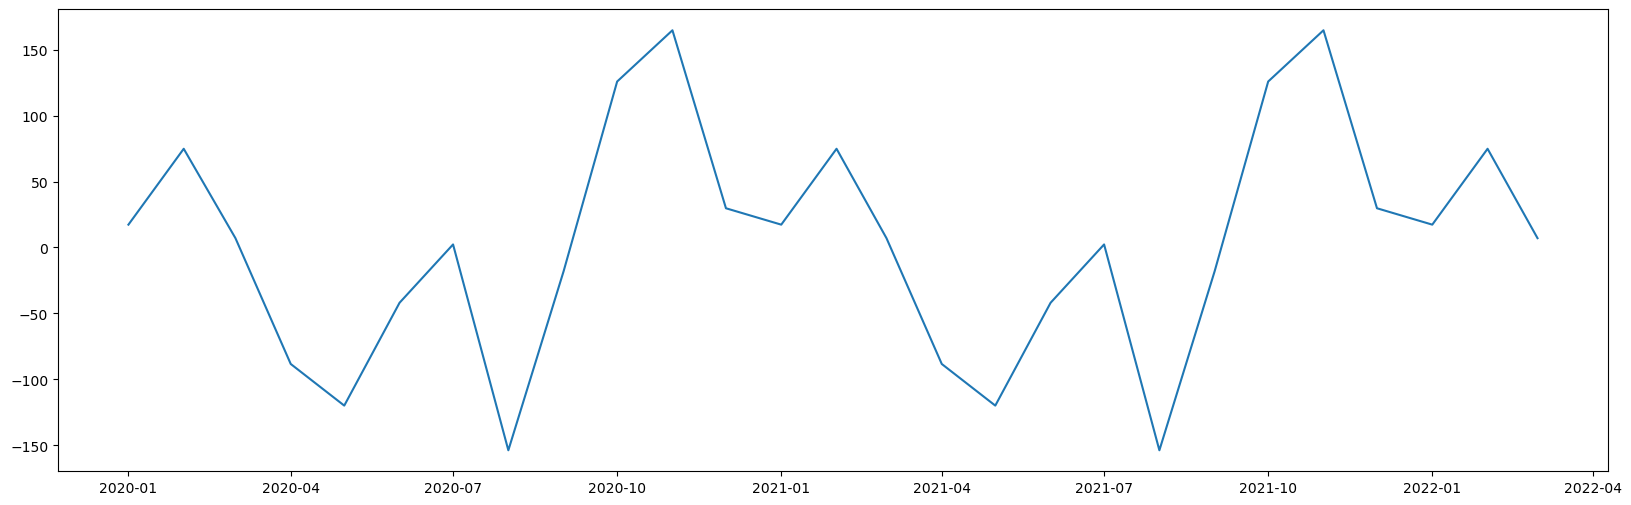

In [104]:
df1=dff[["SKU","Month","Quantity_Sales","Profit_Center"]]

df1.head()

df1.Month=pd.to_datetime(df1.Month,dayfirst=True)

s1=df1.groupby(["SKU","Month"]).Quantity_Sales.sum()
s1

plt.figure(figsize=(20,6))
k=1
for i in df1.SKU.unique():
    df1_temp=s1.loc[i]
    ss=seasonal_decompose(df1_temp)
    
    #plt.subplot(len(df1.SKU.unique()),1,k)
    plt.plot(ss.seasonal)
    plt.show()
    k=k+1
    if k==2:
        break

In [86]:
df4=pd.merge(df3,df1.groupby(by=["Profit_Center"])["Quantity_Sales"].agg({"sum"}).reset_index(),on=["Profit_Center"])
df4["%Share"]=df4["sum_x"]/df4["sum_y"]
df4.columns=["Profit_Center","SKU","SKU_QtyTotal","Profit_Center_QtyTotal","%Share"]

t=[]

for i in df4.Profit_Center.unique():
    print(i)
    t.append(df4[df4["Profit_Center"]==i].sort_values("SKU_QtyTotal",ascending=False).reset_index().drop("index",axis=1).iloc[0:2])
print(t[0])
print(t[1])

Cookie
Cracker
  Profit_Center SKU  SKU_QtyTotal  Profit_Center_QtyTotal    %Share
0        Cookie   B         74705                  107013  0.698093
1        Cookie   A         32308                  107013  0.301907
  Profit_Center SKU  SKU_QtyTotal  Profit_Center_QtyTotal    %Share
0       Cracker   C         14462                   28811  0.501961
1       Cracker   D         14349                   28811  0.498039


<AxesSubplot:xlabel='Month'>

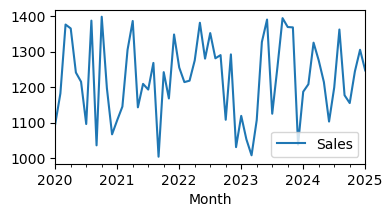

In [87]:
## Forecastng for Cookie

### Time Series Start:

df=df1[df1.SKU==t[0].SKU[0]][["Month","Quantity_Sales"]]
df.Month=pd.to_datetime(df.Month)
df.set_index(["Month"],inplace=True)

df.columns=["Sales"]
df.plot(figsize=(4,2))

In [88]:
df["Sales_log"]=np.log(df["Sales"])

df.head(2)

,Sales,Sales_log
Month,,
2020-01-01,1096,6.999422
2020-02-01,1182,7.074963


In [89]:
### Testing For Stationarity

from statsmodels.tsa.stattools import adfuller
#adfuller(df['Sales'])
#Ho: It is non stationary
#H1: It is stationary
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

adfuller_test(df['Sales'].dropna())

## Differencing
df['Sales First Difference'] = df['Sales'] - df['Sales'].shift(1)
df['Sales Log First Difference']=df['Sales_log']-df['Sales_log'].shift(1)
#df.head()

## ADF for First Difference
adfuller_test(df['Sales First Difference'].dropna())

#### It is stationary after first difference without any transformation

#also checking for log model 
#adfuller_test(df['Sales Log First Difference'].dropna())

ADF Test Statistic : -7.026546287575987
p-value : 6.34284146982657e-10
#Lags Used : 0
Number of Observations Used : 60
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary
ADF Test Statistic : -7.896590956684876
p-value : 4.2945586223792715e-12
#Lags Used : 2
Number of Observations Used : 57
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


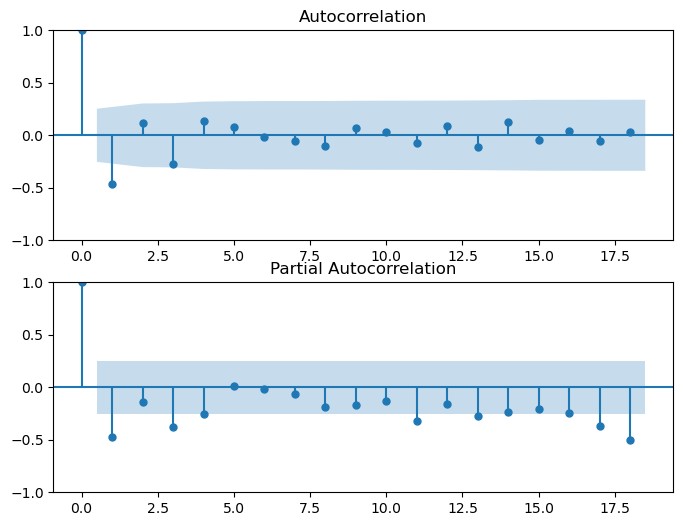

In [90]:
### PACF and ACF
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['Sales First Difference'].dropna(),ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['Sales First Difference'].dropna(),ax=ax2)

In [91]:
df['Sales']

Month
2020-01-01    1096
2020-02-01    1182
2020-03-01    1376
2020-04-01    1365
2020-05-01    1241
              ... 
2024-09-01    1177
2024-10-01    1155
2024-11-01    1244
2024-12-01    1305
2025-01-01    1247
Name: Sales, Length: 61, dtype: int64

<AxesSubplot:title={'center':'Seasonality'}, xlabel='Month'>

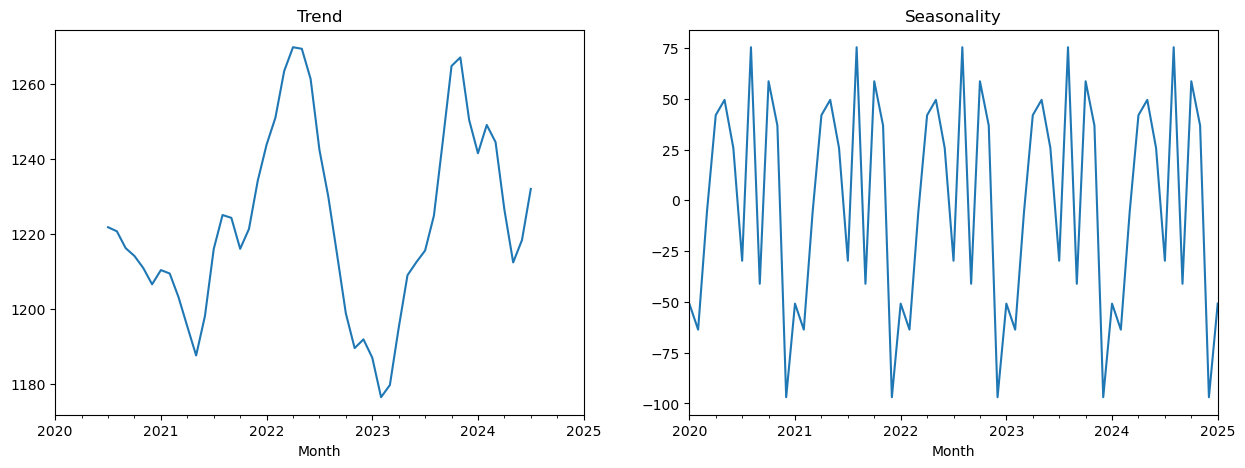

In [100]:
### Decomposition
ss=seasonal_decompose(df["Sales"])
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)        
plt.title("Trend")
ss.trend.plot()
plt.subplot(1,2,2)
plt.title("Seasonality")
ss.seasonal.plot()

<AxesSubplot:title={'center':'Residual'}, xlabel='Month'>

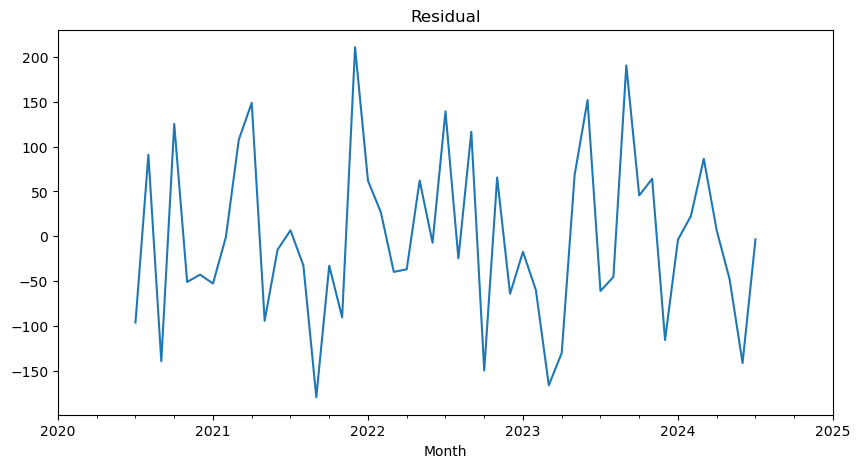

In [98]:
ss.resid.plot(figsize=(10,5),title="Residual")

In [106]:
### Auto Arima 

l1=.75 #train and test split
l=round(l1*len(df))

train=df['Sales'].iloc[:l,]
test=df['Sales'].iloc[l:,]

len(train)

from pmdarima.arima import ndiffs
kpss_diffs = ndiffs(train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)
n_diffs   

import pmdarima as pm
model = pm.auto_arima(df['Sales'], 
                        m=12, seasonal=True,
                      start_p=0, start_q=0, max_order=4, test='adf',error_action='ignore',  
                           suppress_warnings=True, d=n_diffs,  #D=0 was not capturing seasonality
                      stepwise=True, trace=True)

model1=model.fit(train)
model1.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=775.682, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=765.169, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=773.699, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=763.216, Time=0.03 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=765.127, Time=0.08 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=767.152, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=764.099, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=761.263, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=763.211, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=763.167, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   46
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -284.468
Date:                Sun, 11 Jun 2023   AIC                            572.936
Time:                        14:38:53   BIC                            576.550
Sample:                    01-01-2020   HQIC                           574.283
                         - 10-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5066      0.131     -3.865      0.000      -0.763      -0.250
sigma2      1.797e+04   4832.335      3.718      0.000    8495.758    2.74e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                 1.14
Prob(Q):                              0.65   Prob(JB):                         0.57
Heteroskedasticity (H):               0.80   Skew:                            -0.07
Prob(H) (two-sided):                  0.67   Kurtosis:                         2.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Train Set mape: 8.851732310830743
Test set accuracy 0.9883093082122196
Test set mape: 12.864179592234098
Test set accuracy 0.9799134866553987


<AxesSubplot:title={'center':'Test Set'}, xlabel='Month'>

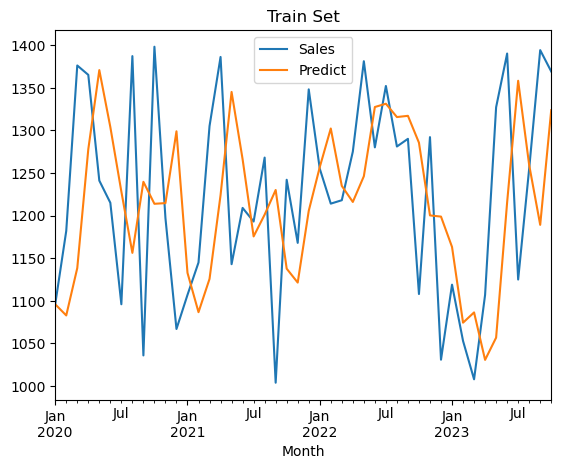

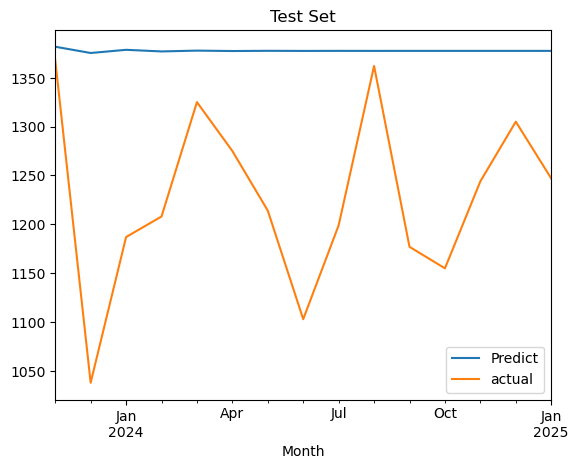

In [107]:
### Model Evaluation:
s=model1.predict_in_sample()
s[0]=df["Sales"][0]

temp=pd.DataFrame(train)
temp["Predict"]=s
print("Train Set mape:",np.mean((np.abs(temp["Sales"][0:l]-temp["Predict"]))*100/temp["Sales"][0:l]))
print("Test set accuracy",1-np.sum(np.square(temp["Predict"]-temp["Sales"]))/np.sum(np.square(temp["Sales"])))
temp[["Sales","Predict"]].plot(title="Train Set") #train

temp2=pd.DataFrame(model1.predict(len(test)))
temp2.columns=["Predict"]
temp1=test.to_list()
print("Test set mape:",np.mean((np.abs(temp1-temp2["Predict"]))*100/temp1)) #test
print("Test set accuracy",1-np.sum(np.square(temp1-temp2["Predict"]))/np.sum(np.square(temp1)))

temp2["actual"]=temp1
temp2.index=test.index
temp2.plot(title="Test Set")

In [108]:
from sklearn.metrics import mean_squared_error
print("MSE for Test Data")
np.sqrt(mean_squared_error(temp1,temp2["Predict"])) #rmse test

MSE for Test Data


174.37333514031596

Month
2023-11-01    1381.664772
2023-12-01    1375.248914
2024-01-01    1378.499129
2024-02-01    1376.852600
2024-03-01    1377.686716
2024-04-01    1377.264161
2024-05-01    1377.478223
2024-06-01    1377.369781
2024-07-01    1377.424717
2024-08-01    1377.396887
2024-09-01    1377.410985
2024-10-01    1377.403843
2024-11-01    1377.407461
2024-12-01    1377.405629
2025-01-01    1377.406557
Name: Predict, dtype: float64

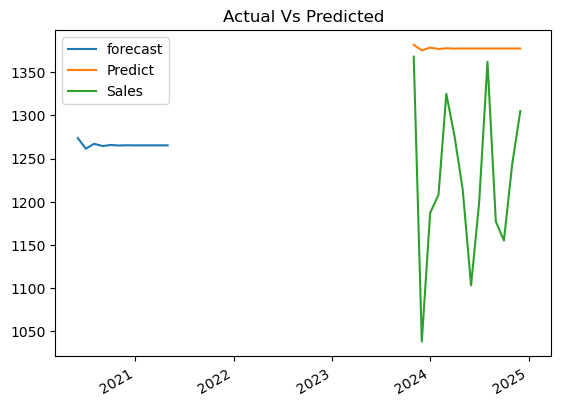

In [114]:
temp2.columns=["Predict","Sales"]

pd.concat([temp,temp2]).plot(title="Actual Vs Predicted")
temp2["Predict"]

MAPE:  8.707993448283375


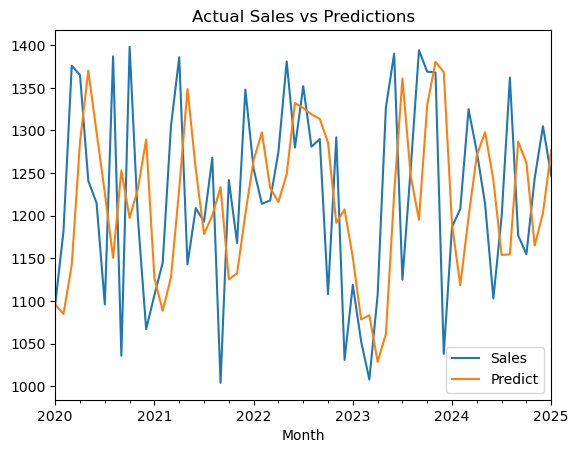

In [110]:
### Model Fitting For Forecast:

model.fit(df['Sales'])

s=model1.predict_in_sample()
s[0]=df["Sales"][0]
temp=df.copy()
temp["Predict"]=s
temp[["Sales","Predict"]].plot(title="Actual Sales vs Predictions")
print("MAPE: ",np.mean((np.abs(temp["Sales"]-temp["Predict"]))*100/temp["Sales"]))

In [119]:
df.index.astype(str)[-1]

'2025-01-01'

<AxesSubplot:title={'center':'Forecast'}>

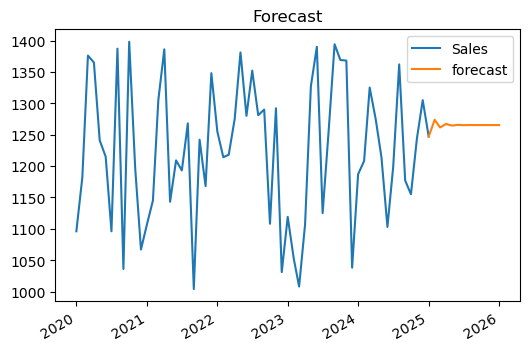

In [120]:
### Result:
# forecasting
num=12  #number of months forecast
fo=pd.DataFrame(model1.predict(num))

fo.columns=["forecast"]
fo.index=pd.Series(pd.date_range(df.index.astype(str)[-1], periods=num, freq="M"))+pd.to_timedelta(pd.np.ceil(1), unit="D")
                                #f
temp=df.reset_index()[["Month","Sales"]][-1:].set_index("Month")
temp.columns=fo.columns
fo=pd.concat([temp,fo])
temp=fo.copy()
fo=pd.concat([df["Sales"],temp])
fo.columns=["Sales","forecast"]
fo.plot(figsize=(6, 4),title="Forecast") 

In [121]:
fo.pct_change()

,Sales,forecast
2020-01-01,NaN,NaN
2020-02-01,0.078467,NaN
2020-03-01,0.164129,NaN
2020-04-01,-0.007994,NaN
2020-05-01,-0.090842,NaN
...,...,...
2025-09-01,0.000000,-0.000092
2025-10-01,0.000000,0.000042
2025-11-01,0.000000,-0.000019
2025-12-01,0.000000,0.000009


In [115]:
## Sarimax Loop For Comparsion

dc=[]
dc1=[]
for p in [0,1,2]:
    for q in [0,1,2]:
        for d in [1,2]:
            
            for P in [0,1,2]:
                for Q in [0,1,2]:
                    for D in [0,1]:
                        #print(p,d,q,P,Q,D)
                        model2=sm.tsa.statespace.SARIMAX(train,order=(p, d, q),seasonal_order=(P,D,Q,12)) 
                        results=model2.fit()
                        
                        ##train evalue
                        fc=pd.DataFrame(results.predict(start=1))
                        fc.columns=["values"]

                        c=pd.DataFrame(train).reset_index()[["Month","Sales"]][:1]
                        c.set_index("Month", inplace=True)
                        c.columns=fc.columns
                        fc=pd.concat([c,fc])
                        fc["forecast"]=fc["values"]
                        fc["Sales"]=df["Sales"]
                    ###wrong
                        #fc[["Sales","values"]].plot(figsize=(6,4),title="pdqPDQ:"+str(p)+str(d)+str(q)+str(P)+str(D)+str(Q))
                        mape1=np.mean((np.abs(fc["Sales"]-fc["values"]))*100/fc["Sales"]) 
                        ###test                       
                        temp=pd.DataFrame(results.forecast(len(test)))
                        temp.columns=["Predict"]
                        temp1=test.to_list()
                        mape=np.mean((np.abs(temp1-temp["Predict"]))*100/temp1)
                        #fc[["Sales","values"]].plot(figsize=(6,4),title="pdqPDQ:"+str(p)+str(d)+str(q)+str(P)+str(D)+str(Q))
                        rmse=np.sqrt(mean_squared_error(temp1,temp["Predict"]))                    
                        dc.append((p,d,q,P,D,Q,rmse,mape,mape1))
                    #Forecast
#Continue 
# error in one of the case so run the below cells seperately.
### comparsion of Sarima Models
compare=pd.DataFrame(dc)
compare.columns=["p","d","q","P","D","Q","rmse","mape","mape_train"]
compare.sort_values(by=["mape","rmse","mape_train"],inplace=True)
#compare[compare.P+compare.Q+compare.D!=0 ].head(10)
compare[abs(compare.mape-compare.mape_train)<5].head(10)

,p,d,q,P,D,Q,rmse,mape,mape_train
194,1,1,2,2,0,1,86.464313,5.594567,8.349977
196,1,1,2,2,0,2,86.236181,5.608217,8.339692
50,0,1,1,2,0,1,86.677302,5.618526,8.345934
46,0,1,1,1,0,2,87.322272,5.643917,8.345632
190,1,1,2,1,0,2,87.445387,5.653987,8.344131
156,1,1,1,2,0,0,86.237766,5.664243,8.183758
84,0,1,2,2,0,0,86.514936,5.677628,8.279509
76,0,1,2,0,0,2,87.197291,5.686385,8.207101
40,0,1,1,0,0,2,87.805760,5.711447,8.361086
184,1,1,2,0,0,2,88.044827,5.716160,8.348086


In [122]:
model2=sm.tsa.statespace.SARIMAX(train,order=(1, 1, 2),seasonal_order=(2,0,1,12)) 
results=model2.fit()
##train evalue
fc=pd.DataFrame(results.predict(start=1))
fc.columns=["values"]
c=pd.DataFrame(train).reset_index()[["Month","Sales"]][:1]
c.set_index("Month", inplace=True)
c.columns=fc.columns
fc=pd.concat([c,fc])
fc["forecast"]=fc["values"]
fc["Sales"]=df["Sales"]
###wrong
#fc[["Sales","values"]].plot(figsize=(6,4),title="pdqPDQ:"+str(p)+str(d)+str(q)+str(P)+str(D)+str(Q))
mape1=np.mean((np.abs(fc["Sales"]-fc["values"]))*100/fc["Sales"]) 
###test                       
temp=pd.DataFrame(results.forecast(len(test)))
temp.columns=["Predict"]
temp1=test.to_list()

<AxesSubplot:xlabel='Month'>

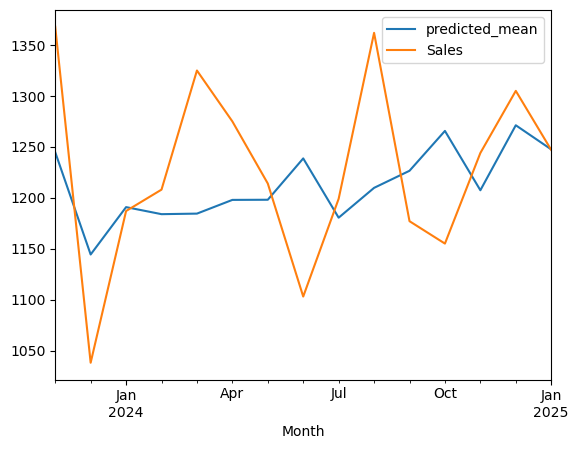

In [158]:
# fc['Sales'].plot()
# fc=fc.append(pd.DataFrame(results.forecast(25)))
results.forecast(len(test)).plot(legend=True)
test.plot(legend=True)

<AxesSubplot:xlabel='Month'>

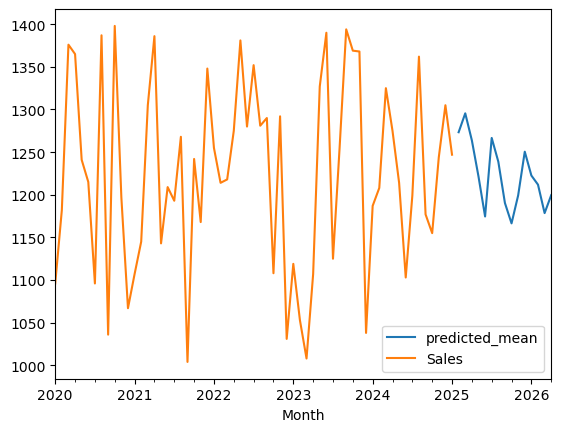

In [159]:
model2=sm.tsa.statespace.SARIMAX(df['Sales'],order=(1, 1, 2),seasonal_order=(2,0,1,12)) 
results=model2.fit()
results.forecast(len(test)).plot(legend=True)
df['Sales'].plot(legend=True)

Sales                         1247.000000
Sales_log                        7.128496
Sales First Difference         -58.000000
Sales Log First Difference      -0.045462
Name: 2025-01-01 00:00:00, dtype: float64

MAPE train :  7.088178595085806
98.74293859821773
MAPE Test :  6.503951411001714
MAPE train :  7.0144026512712845
104.03798166013392
MAPE Test :  7.009654435320388
MAPE train :  8.727474495733658
74.57775747046982
MAPE Test :  4.970028108417348
MAPE train :  7.067840592509715
99.66621412744387
MAPE Test :  6.619937968559956
MAPE train :  7.060428052173924
103.80641638185105
MAPE Test :  6.99291538099507
MAPE train :  8.452731581178575
75.2481447655023
MAPE Test :  4.937711571434937
MAPE train :  6.944047158077956
100.17344410500507
MAPE Test :  6.516955936348418
MAPE train :  6.884959167522074
105.72177954422483
MAPE Test :  6.992212284031545
MAPE train :  8.307703327708111
73.73048001204214
MAPE Test :  4.869615087266401
MAPE :  7.067840592509715
MAPE :  6.619937968559956


Quantity_Sales    1247
Name: 2025-01-01 00:00:00, dtype: int64

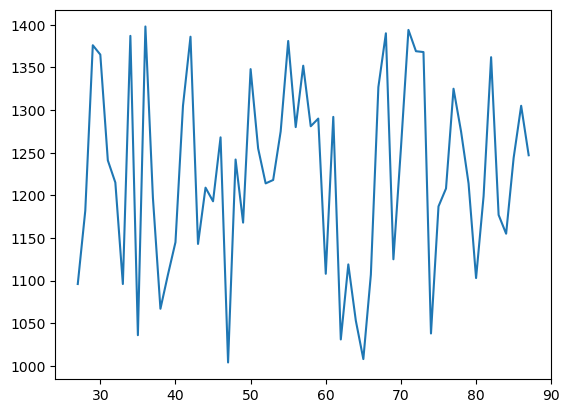

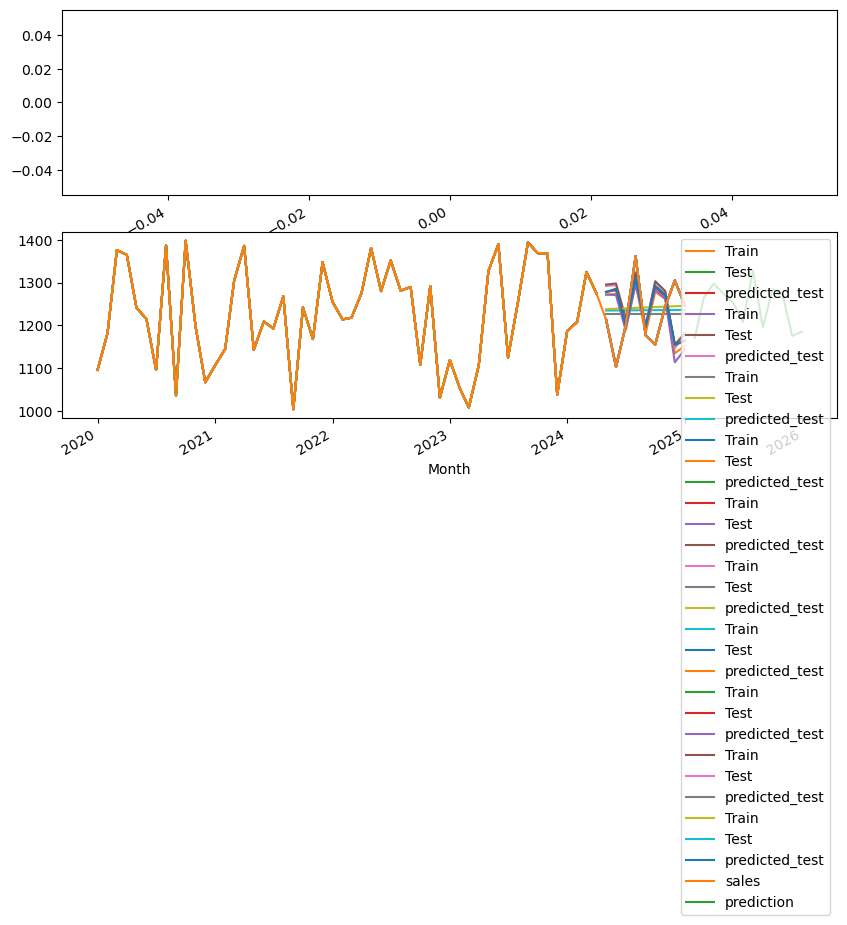

In [163]:
#### We get same model using Auto-Arima/ Sarima
##### Arima end

### Holt winter start
### Holt winters exponential smoothing 

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# df=pd.read_csv("C:/Users/703268354/Downloads/THS_SKU_Forecast_Model_Dataset.csv")
df=dff
df.head(2)

### For Cracker

df1=df[df["SKU"]=="B"]
df1=df1[["Month","Quantity_Sales"]]
df1.Month=pd.to_datetime(df1.Month,dayfirst=True)
df1.head(2)

df1["Quantity_Sales"].plot()

### seasonal decomposition  

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

df2=df1.reset_index()


df2["Year"]=df2["Month"].dt.year
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
df2[(df2.Year==2018)].set_index("Month")["Quantity_Sales"].plot()
plt.subplot(2,1,2)
df2[(df2.Year==2019)].set_index("Month")["Quantity_Sales"].plot()





df1=df1.set_index("Month")

ss=seasonal_decompose(df1, model='multiplicative')





### Train n test split  



train=df1.iloc[:-9]
test=df1.iloc[-9:]

train.shape

train.head(5)

test.shape

test.tail()

dn=[]
for i in ['mul','add',None]:
    for j in ['mul','add',None]:
        from statsmodels.tsa.holtwinters import ExponentialSmoothing

        model=ExponentialSmoothing(train.Quantity_Sales,trend=i, seasonal=j, seasonal_periods=12).fit()

        s=model.predict(0)
        print('MAPE train : ', np.mean((np.abs(train['Quantity_Sales']-s))*100/train['Quantity_Sales']))  #train
        mptrain=np.mean((np.abs(train['Quantity_Sales']-s))*100/train['Quantity_Sales'])
        test_pred=model.forecast(len(test))

        test_pred

        train['Quantity_Sales'].plot(legend=True, label='Train', figsize=(10,6))
        test['Quantity_Sales'].plot(legend=True, label='Test')

        test_pred.plot(legend=True, label='predicted_test')

        ### Model evaluation

        from sklearn.metrics import mean_squared_error

        rmse=np.sqrt(mean_squared_error(test,test_pred))
        print(rmse)
        forecast=pd.DataFrame(test_pred,columns=["pred"])
        forecast

        print('MAPE Test : ', np.mean((np.abs(test['Quantity_Sales']-forecast["pred"]))*100/test['Quantity_Sales']))
        dn.append((i,j,mptrain,rmse,np.mean((np.abs(test['Quantity_Sales']-forecast["pred"]))*100/test['Quantity_Sales'])))

dn=pd.DataFrame(dn)
dn.columns=["trend","Seasonality","MAPE_Train","RMSE","MAPE_Test"]
dn.sort_values(by=["MAPE_Test","RMSE"])



### Holt winters model

from statsmodels.tsa.holtwinters import ExponentialSmoothing

model=ExponentialSmoothing(train.Quantity_Sales,trend='add', seasonal='mul', seasonal_periods=12).fit()

s=model.predict(0)
print('MAPE : ', np.mean((np.abs(train['Quantity_Sales']-s))*100/train['Quantity_Sales']))  #train

test_pred=model.forecast(len(test))

test_pred

train['Quantity_Sales'].plot(legend=True, label='Train', figsize=(10,6))
test['Quantity_Sales'].plot(legend=True, label='Test')

test_pred.plot(legend=True, label='predicted_test')

### Model evaluation

from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(test,test_pred))

forecast=pd.DataFrame(test_pred,columns=["pred"])
forecast

print('MAPE : ', np.mean((np.abs(test['Quantity_Sales']-forecast["pred"]))*100/test['Quantity_Sales']))

### final model

final_model=ExponentialSmoothing(df1.Quantity_Sales,trend='mul', seasonal='mul', seasonal_periods=12).fit()

pred=final_model.forecast(12)

ff=pd.concat([pred,df1])
ff.columns=[["Predictions","Actuals"]]
ff.iloc[37]["Predictions"]=ff.iloc[37]["Actuals"]
#ff

forecast=pd.DataFrame(pred,columns=["pred"])

forecast

df1["Quantity_Sales"].plot(legend=True, label='sales', figsize=(10,6))
pred.plot(legend=True, label='prediction')

df1.iloc[-1]


### holt winter end
 